In [3]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [4]:
# dimensions of our images
img_width, img_height = 192, 256
# directory and image information
train_data_dir = '../input/ds000245a/data2/train'
validation_data_dir = '../input/ds000245a/data2/validation'
# epochs = number of passes of through training data
# batch_size = number images processed at same time
train_samples = 340
validation_samples = 68
epochs = 50
batch_size = 34

In [5]:
#build the Inception V3 network, use pretrained weights from ImageNet
#remove top fully connected layers by include_top=False
#base_model1 = applications.InceptionV3(weights='imagenet')
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

2022-06-02 17:02:10.275064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 17:02:10.502933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 17:02:10.504033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-02 17:02:10.505886: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 1s 0us/step


In [9]:
# build a classifier model to put on top of the convolutional model
# This consists of a global average pooling layer and a fully connected layer with 256 nodes 
# Then apply dropout and sigmoid activation
model_top = Sequential() 
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),
model_top.add(Dense(32, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

#Compile model using Adam optimizer with common values and binary cross entropy loss
#Use low learning rate (lr) for transfer learning
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Some on-the-fly augmentation options
train_datagen = ImageDataGenerator(
# Rescale pixel values to 0-1 to aid CNN processing
rescale= 1./255)
#shear_range=0.2, # 0-1 range for shearing
#zoom_range=0.2, # 0-1 range for zoom
#rotation_range=20,
#width_shift_range=0.2, # 0-1 range horizontal translation
#height_shift_range=0.2, # 0-1 range vertical translation
#horizontal_flip=True # set True or False

val_datagen = ImageDataGenerator(
rescale=1./255)

In [11]:
# Directory, image size, batch size already specified above
# Class mode is set to 'binary' for a 2-class problem
# Generator randomly shuffles and presents images in batches to the network
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width), 
    batch_size=batch_size,
    class_mode='binary')

Found 340 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [12]:
# Fine-tune the pretrained Inception V3 model using the data generator
# Specify steps per epoch (number of samples/batch_size)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#checkpoint_filepath = '/content/drive/MyDrive/ds000245/data2'
mc = ModelCheckpoint('./best_model5.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size, 
    epochs=epochs, validation_data=validation_generator, 
    validation_steps=validation_samples // batch_size,
    #verbose=0,
    callbacks=[mc])

2022-06-02 17:03:18.464288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-02 17:03:25.409636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


10/10 [==============================] - 17s 344ms/step - loss: 0.3571 - accuracy: 0.8235 - val_loss: 1.1825 - val_accuracy: 0.6471

Epoch 00001: val_accuracy improved from -inf to 0.64706, saving model to ./best_model5.h5
Epoch 2/50
10/10 [==============================] - 2s 192ms/step - loss: 0.1247 - accuracy: 0.9588 - val_loss: 7.8131 - val_accuracy: 0.6176

Epoch 00002: val_accuracy did not improve from 0.64706
Epoch 3/50
10/10 [==============================] - 2s 181ms/step - loss: 0.0462 - accuracy: 0.9882 - val_loss: 1.6552 - val_accuracy: 0.7647

Epoch 00003: val_accuracy improved from 0.64706 to 0.76471, saving model to ./best_model5.h5
Epoch 4/50
10/10 [==============================] - 2s 182ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 10.5975 - val_accuracy: 0.5735

Epoch 00004: val_accuracy did not improve from 0.76471
Epoch 5/50
10/10 [==============================] - 2s 182ms/step - loss: 0.1257 - accuracy: 0.9706 - val_loss: 5.7682 - val_accuracy: 0.5000

E

In [13]:
import pandas as pd

df=pd.DataFrame(history.history)
df.index = df.index +1
df

,loss,accuracy,val_loss,val_accuracy
1,0.357062,0.823529,1.182527,0.647059
2,0.124697,0.958824,7.813125,0.617647
3,0.046233,0.988235,1.655177,0.764706
4,0.016377,1.000000,10.597509,0.573529
5,0.125671,0.970588,5.768238,0.500000
6,0.111612,0.961765,26.665934,0.500000
7,0.101535,0.961765,44.038452,0.500000
8,0.059018,0.973529,32.120766,0.529412
9,0.014300,0.997059,16.686081,0.602941
10,0.009673,0.997059,20.831299,0.558824


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


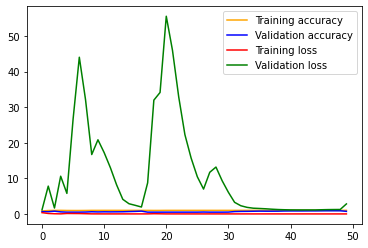

In [14]:
# import matplotlib library, and plot training cuve
import matplotlib.pyplot as plt

print(history.history.keys())
plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

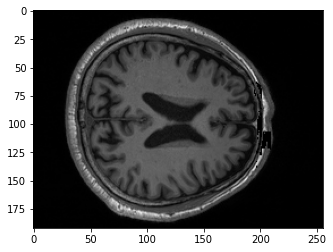

Predicted: [[0.05149526]] Healthy


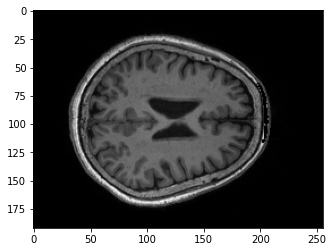

Predicted: [[0.99992883]] PD


In [40]:
from keras.models import load_model
saved_model = load_model('best_model5.h5')
# import numpy and keras preprocessing libraries
import numpy as np
from keras.preprocessing import image
# load, resize, and display test images
img_path='../input/ds000245a/data2/test/healthy/sub-CTL14_T1w.ni_z149.png' 
img_path2='../input/ds000245a/data2/test/pd/sub-ODP14_T1w.ni_z165.png'
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()
# convert image to numpy array, so Keras can render a prediction
img = image.img_to_array(img)
# expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch size, height, width, channels)
# rescale pixel values to 0-1
x = np.expand_dims(img, axis=0) * 1./255
# get prediction on test image
score = saved_model.predict(x)
print('Predicted:', score, 'Healthy' if score < 0.5 else 'PD')
# display and render a prediction for the 2nd image
plt.imshow(img2)
plt.show()
img2 = image.img_to_array(img2)
x1 = np.expand_dims(img2, axis=0) * 1./255
score2 = saved_model.predict(x1)
print('Predicted:', score2, 'Healthy' if score2 < 0.5 else 'PD')

In [36]:
test_samples = 34
test_datagen = ImageDataGenerator(
rescale=1./255) 

test_generator = test_datagen.flow_from_directory(
    '../input/ds000245a/data2/test',
    class_mode='binary',
    target_size=(img_height, img_width),
    batch_size=batch_size)

result = saved_model.evaluate(test_generator, steps=test_samples//batch_size)

Found 34 images belonging to 2 classes.
1/1 [==============================] - 2s 2s/step - loss: 0.9241 - accuracy: 0.7059


In [37]:
print("test loss, test acc:", result)

test loss, test acc: [0.924088180065155, 0.7058823704719543]
